# Recommendation Systems and Ranking Problems

**Aim**: We want to learn basic principles of how recommendation systems work and how they are implemented. We will build up a simple movie recommendation system with the *MovieLens* dataset. 

**Source**: Chapter 9 from *Igual, L., & Seguí, S. (2017). Introduction to data science. Springer International Publishing.* and corresponding Jupyter Notebook.

Recommendation systems help to answer questions like:

*    Which movie should I watch next? (Netflix movie recommendation)
*    Which music will I like? (Spotify music recommendation)
*    Which TV should I buy? (Amazon recommendation)
*    Which is the best place for me and my family to travel to?

**Nowadays, recommendation systems are present is a huge variety of applications.**

## How do Recommendation Systems work?

Most of the algorithms take one of the two basic approaches:
    
*    **Content-based filtering (CBF)**

     Paradigm: *Show me more of the same what I have liked*

    This approach will recommend items which are similar to those the user liked before  and the recommendations are based on    descriptions of items and a profile of the user's preferences. 

    Most important: computation of the similarity between items


*    **Collaborative filtering (CF)**

     Paradigm: *Tell me what is popular among my like-minded users*

     Working hypothesis: similar users tend to like similar items
     
     Analyze a large number of data related to the behavior, activities or tastes of users and predicting what users will like
     
     Cold start problem
     
     Collaborative filtering has two types:
    
     *    user-based CF: find similar users to me and recommend what they liked

     *    item-based CF: find similar items to those I previously liked; people who buy x also buy y; **This is a popular approach used by companies like Amazon**
     
     
*    **Hybrid Recommenders**

*    **Knowledge-Based recommendation systems**

*    **Graph-based recommendation systems**

## Modeling User Preferences

Both CBF and CF require to understand the user preferences.

The most common types of labels used to estimate the user preferences are:

*    **boolean**: is bought? is viewed?
*    **numerical**: star ranking
*    **up-down expressions**: like, neutral, dislike
*    ...

## Evaluating Recommenders

When dealing with numerical labels, as the 5-star ratings, the most common way to validate a recommendation system is based on their prediction value, i.e., the capacity to predict the user's choices. Standard functions are the *RMSE, precision, recall, ROC curve, cost curve*. There are several other ways to evaluate the systems. Recently other indirect functions have become popular, like *diversity, novelty, coverage, serendipity*.

**A/B-testing** is very common in this regard. We are interested in measuring how user behavior changes when the user is interacting with different recommendation systems.

# Preamble

In [1]:
# Common imports
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 
import pickle # we have to import a pickle file
import os 
# from datetime import timedelta, datetime

# maximum number of columns
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Use Case: Implement a movie recommendation system

We will construct a user-based collaborative filtering method with the MovieLens dataset. For further details visit.  https://grouplens.org/datasets/movielens/

The dataset from Iguai &Segui (2017) can be downloaded from: http://files.grouplens.org/datasets/movielens/ml-100k.zip. 

**Citing Igual & Segui (2017) about the dataset:** 

This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version. Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens 100K Dataset (ml-100k-zip). Working with this lite version has the benefit of less computational costs, while we will also get the skills required on user-based recommender systems.

In [3]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
from math import isnan

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./ml-100k/ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./ml-100k/ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('./ml-100k/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# Construction of the data frame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("We have collected "+ str(data.shape[0]) +" ratings")
print("We have collected ", data.user_id.nunique()," users")
print("We have collected ", data.movie_id.nunique(), " movies")
display(data.head())

We have collected 100000 ratings
We have collected  943  users
We have collected  1682  movies


,user_id,title,movie_id,rating,release_date,sex,age
0,196,Kolya (1996),242,3,24-Jan-1997,M,49
1,305,Kolya (1996),242,5,24-Jan-1997,M,23
2,6,Kolya (1996),242,4,24-Jan-1997,M,42
3,234,Kolya (1996),242,4,24-Jan-1997,M,60
4,63,Kolya (1996),242,3,24-Jan-1997,M,31


In [5]:
list(data.title.unique())

['Kolya (1996)',
 'Mrs. Doubtfire (1993)',
 "Muriel's Wedding (1994)",
 'Shall We Dance? (1996)',
 'Stand by Me (1986)',
 'Ace Ventura: Pet Detective (1994)',
 'Mrs. Brown (Her Majesty, Mrs. Brown) (1997)',
 'Raising Arizona (1987)',
 'Being There (1979)',
 'Truth About Cats & Dogs, The (1996)',
 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)',
 'Birdcage, The (1996)',
 'English Patient, The (1996)',
 'Home Alone (1990)',
 'American President, The (1995)',
 'Babe (1995)',
 'Harold and Maude (1971)',
 'Up in Smoke (1978)',
 'Four Weddings and a Funeral (1994)',
 'While You Were Sleeping (1995)',
 'Men in Black (1997)',
 'Kids in the Hall: Brain Candy (1996)',
 'Groundhog Day (1993)',
 'Boogie Nights (1997)',
 "Marvin's Room (1996)",
 'Cold Comfort Farm (1995)',
 'Adventures of Priscilla, Queen of the Desert, The (1994)',
 'Secrets & Lies (1996)',
 'Van, The (1996)',
 'Waiting for Guffman (1996)',
 'Nutty Professor, The (1996)',
 'Fish Called Wanda, A (1988)',
 'Mig

In [3]:
data.groupby('user_id')['movie_id'].nunique().sort_values()

user_id
202     20
441     20
685     20
34      20
36      20
      ... 
276    518
450    540
13     636
655    685
405    737
Name: movie_id, Length: 943, dtype: int64

If you explore the dataset in detail, you will see that it  consists of:
<ul>
<li>100,000 ratings from 943 users of 1682 movies. Ratings are from 1 to 5.</li>
<li>Each user has rated at least 20 movies.</li>
<li>Simple demographic info for the users (age, gender). Occupation, zip also available</li>
<li>Take a look at the README</li>  
</ul>

<br>The following table ilustrates the problem. This toy dataset consists on 4 users and 4 items.  Users 1, 2 and 3 have seen all the movies while user 4 has only seen Superman and Star Wars. So, the problem consist on prediction which movie, Matrix or Spiderman, will be more likely for the user 4.
<table style="width:60%">
  <tr>
    <td></td>
    <td>Superman</td> 
    <td>Star Wars 1</td>
    <td>Matrix</td>
    <td>Spiderman</td>
    
  </tr>
  <tr>
    <td>user1</td>
    <td>3</td> 
    <td>3.5</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user2</td>
    <td>3.5</td> 
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>user3</td>
    <td>3</td> 
    <td>4</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user4</td>
    <td>3.5</td> 
    <td>5</td>
    <td><font color="red"><b>?</b></font></td>
    <td><font color="red"><b>?</b></font></td>
  </tr>
</table>

# Development of user-based collaborative filtering system

In order to create a user-based collaborative recommendation system we have to define

*    a prediction function $pred$
*    a similarity function $sim$
*    an evalulation function $RMSE$

We define 

*    a recommended movie $p$ from a set of movies $P$
*    a given user $a$ from the set of users $B$

We need to see the taste similarity between the users $B$ and a user $a$:

$$pred(a,p) = \frac{\sum_{b \in B}{sim(a,b)*(r_{b,p})}}{\sum_{b \in B}{sim(a,b)}}$$

where $sim(a,b)$ is the similarity between two users and $r_{b,p}$ the rating of $p$ by $b$.

![](recommender_system_pred_sim_function.png)

## User Similarity Function

The computation of the similarity between users is one of the most critical steps in the CF algorithms. The basic idea behind the similarity computation between two users $a$ and $b$ is to first isolate the set $P$ of items rated by both users and then apply a similarity computation technique.

In [6]:
# dataframe with the data from user 1
data_user_1 = data[data.user_id==1]
# dataframe with the data from user 2
data_user_2 = data[data.user_id==6]
# We first compute the set of common movies
common_movies = set(data_user_1.movie_id).intersection(data_user_2.movie_id)
print("Number of common movies",len(common_movies))
print("\n")

# creat the subdataframe with only with the common movies
mask = (data_user_1.movie_id.isin(common_movies))
data_user_1 = data_user_1[mask]
display(data_user_1[['title','rating']].head())

mask = (data_user_2.movie_id.isin(common_movies))
data_user_2 = data_user_2[mask]
display(data_user_2[['title','rating']].head())

Number of common movies 96




,title,rating
14,Kolya (1996),5
940,Raising Arizona (1987),4
1306,"Truth About Cats & Dogs, The (1996)",5
2677,Babe (1995),1
3073,Four Weddings and a Funeral (1994),3


,title,rating
2,Kolya (1996),4
885,Raising Arizona (1987),5
1255,"Truth About Cats & Dogs, The (1996)",2
2636,Babe (1995),4
3022,Four Weddings and a Funeral (1994),3


Once the set of ratings for all movies common to the two users has been obtained, we can compute the **user similarity**. These are some of the most common similarity functions used in CF methods: 

   <ul>
    <li>Euclidean distance</li>
    $$sim(a,b) = \sqrt{\sum_{p \in P}{(r_{a,p} - r_{b,p})^2}}$$
    <br>
    <li>Pearson Correlation</li>
    $$sim(a,b) = \frac{\sum_{p\in P} (r_{a,p}-\bar{r_a})(r_{b,p}-\bar{r_b})}{\sqrt{\sum_{p \in P}(r_{a,p}-\bar{r_a})²}\sqrt{\sum_{p \in P}(r_{b,p}-\bar{r_b})²}}$$
    <br>
    <li>Cosine distance</li>
    $$ sim(a,b) = \frac{\vec{a}· \vec{b}}{|\vec{a}| * |\vec{b}|}$$
    <br>
    </ul>
  
<br>
Where: 

* $sim(a,b)$ is the similarity between user $a$ and user $b$
* $P$ is the set of common rated movies by user $a$ and $b$
* $r_{a,p}$ is the rating of movie $p$ by user $a$
* $\bar{r_a}$ is the mean rating given by user $a$

<br>

<h4>Some issues to take into accout</h4>
<ul>
<li>Pearson Correlation used to work better than euclidean distance since it is based more on the ranking than on the values.</li>
<li>Cosine distance is usually used when our data is binary/unary, i.e. like vs. not like  or buy vs. not buy.</li>
<li>What happens if two users have very few items in common?</li>
</ul>

Let us define the Euclidean and Pearson functions:

In [7]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
import seaborn as sns;

# Returns a distance-based similarity score for person1 and person2
def SimEuclid(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')    
    if len(rep)==0:
        return 0
    if(len(rep)<min_common_items):
        return 0
    #return distEuclid(rep['rating_x'],rep['rating_y']) 
    return(1.0/(1.0+euclidean(rep['rating_x'],rep['rating_y'])))

# Returns a pearsonCorrealation-based similarity score for person1 and person2
def SimPearson(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
    if len(rep) < 2 :
        return 0    
    if(len(rep)<min_common_items):
        return 0    
    res=pearsonr(rep['rating_x'],rep['rating_y'])[0]
    if(isnan(res)):
        return 0
    return(res)

In [8]:
# Similarity between users 1 and 8 and users 1 and 31:
print("Euclidean Similarity",SimEuclid(data,1,8))
print("Pearson Similarity",SimPearson(data,1,8))
print("-----")
print("Euclidean Similarity",SimEuclid(data,1,31))
print("Pearson Similarity",SimPearson(data,1,31))

Euclidean Similarity 0.1566130288262323
Pearson Similarity 0.6920863660773593
-----
Euclidean Similarity 0.1757340838011157
Pearson Similarity -0.09221388919541466


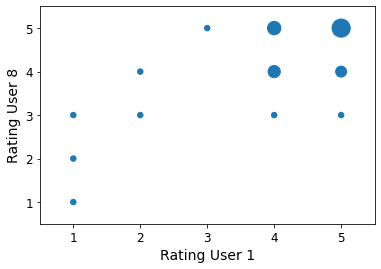

In [9]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==8 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)

fig = plt.figure(figsize=(6,4))
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(8))
plt.axis([0.5,5.5,0.5,5.5])
plt.show()

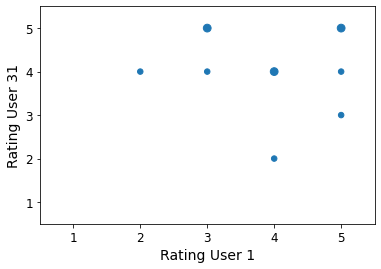

In [10]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==31 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]

fig = plt.figure(figsize=(6,4))
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(31))
plt.axis([0.5,5.5,0.5,5.5])
plt.show()

The bigger the dot, the larger the set of movies rated with the corresponding values.

We observe that ratings from user 1 are more correlated with ratings from user 8 than from user 31. However, we also observe that the Euclidean similarity between user 1 and user 31 is closer than between user 1 and user 8.

## Train-Test Split and Evaluation

In order to validate the system, we will divide the dataset into two different sets: one called $X\_train$ containing  $80\%$ of the data from each user; and another called $X\_test$, with the remaining $20\%$ of the data from each user. In the following code we create a function for that purpose:

Users who are in the training set are not allowed to be in the test set.

In [11]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return(df)

data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]
print(data_train.shape)
print(data_test.shape)
print(data_train.index & data_test.index)

print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")
print("The whole data frame has ", data.movie_id.nunique(), " movies")

(79619, 8)
(20381, 8)
Int64Index([], dtype='int64')
Training data_set has 79619 ratings
Test data set has 20381 ratings
The whole data frame has  1682  movies


Once the data is divided in these sets, we can build a model with the training set and evaluate its performance using the test set. In our case, the evaluation will be performed using the standard RMSE:

In [12]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

# Recommendation System Class

We define our recommendation system with a Python class. This class consists of a *constructor* and two methods: *learn* and *estimate*. In the *learn* method the user's similarities are computed and stored into a Python dictionary. **This is really simple but expensive!** More complex algorithms can be used in order to improve the computational cost. 

In the *estimate* method the score for a movie and a user is predicted.

First of all, let us discuss how to set up a similarity matrix for all users:

In [13]:
testing = data[:100]

In [14]:
testing.head(20)

,user_id,title,movie_id,rating,release_date,sex,age,for_testing
0,196,Kolya (1996),242,3,24-Jan-1997,M,49,False
1,305,Kolya (1996),242,5,24-Jan-1997,M,23,False
2,6,Kolya (1996),242,4,24-Jan-1997,M,42,False
3,234,Kolya (1996),242,4,24-Jan-1997,M,60,False
4,63,Kolya (1996),242,3,24-Jan-1997,M,31,False
5,181,Kolya (1996),242,1,24-Jan-1997,M,26,False
6,201,Kolya (1996),242,4,24-Jan-1997,M,27,False
7,249,Kolya (1996),242,5,24-Jan-1997,M,25,False
8,13,Kolya (1996),242,2,24-Jan-1997,M,47,False
9,279,Kolya (1996),242,3,24-Jan-1997,M,33,False


In [15]:
""" Prepare data structures for estimation. Similarity matrix for users """
allUsers=set(testing['user_id'])

In [16]:
sim = pd.DataFrame(np.sum([0]), columns = testing.user_id.unique(), index=testing.user_id.unique())
display(sim)

,196,305,6,234,63,181,201,249,13,279,145,90,271,18,1,207,14,113,123,296,154,270,240,144,21,239,111,129,131,226,306,173,2,205,195,199,202,206,35,34,204,30,209,9,12,40,331,86,139,309,354,360,355,416,408,417,428,440,439,451,460,461,463,473,486,492,497,500,523,520,532,485,533,537,539,566,574,568,592,594,597,617,624,628,639,651,655,641,673,697,680,707,695,675,721,724,720,743,733,740
196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
print('Shape of similarity matrix: ', sim.shape)

Shape of similarity matrix:  (100, 100)


In [17]:
class CollaborativeFiltering:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self, DataFrame, similarity=SimPearson):
        """ Constructor """
        self.sim_method = similarity# Gets recommendations for a person by using a weighted average
        self.df         = DataFrame
        self.sim        = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        self.sim = {}
        for person1 in allUsers:
            self.sim.setdefault(person1, {})
            a=data_train[data_train['user_id']==person1][['movie_id']]
            data_reduced=pd.merge(data_train,a,on='movie_id')
            for person2 in allUsers:
                # no es comparem am nosalres mateixos
                if person1==person2: continue
                self.sim.setdefault(person2, {})
                if(person1 in self.sim[person2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,person1,person2)
                if(sim<0):
                    self.sim[person1][person2]=0
                    self.sim[person2][person1]=0
                else:
                    self.sim[person1][person2]=sim
                    self.sim[person2][person1]=sim
                
    def estimate(self, user_id, movie_id):
        totals={}
        movie_users=self.df[self.df['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        for other in allUsers:
            if user_id==other: continue 
            rating_num += self.sim[user_id][other] * float(movie_users[movie_users['user_id']==other]['rating'])
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return(rating_num/rating_den)

In [18]:
import warnings
warnings.filterwarnings("ignore")

reco = CollaborativeFiltering(data_train)
reco.learn()
reco.estimate(user_id=2,movie_id=1)

3.866535462426803

In [29]:
reco.estimate(user_id=3,movie_id=9)

3.9068157089517666

## Evaluation of the Recommendation System

For the evaluation of the system we define a function *evaluate*. This function estimates the score for all items in the test set $X_{test}$ and compares them with the real values using the RMSE.

In [30]:
def evaluate(estimate_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([estimate_f(u,i) if u in data_train.user_id else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

In [31]:
print('RMSE for Collaborative Recommendation System: %s' % evaluate(reco.estimate,data_train,data_test))

RMSE for Collaborative Recommendation System: 1.0571703249451454


## Further Improvement

This result can be improved by using a bigger dataset. Here we look at some other possibilities to improve the recommendation system.

Some people usually rank movies higher or lowe than others, therefore we take into account the user mean value:

<div class  = "alert alert-success">IDEA 1:<p>
Modify the Recomender System using as a prediction function the following equation:
$$pred(a,p) = \bar{r_a} + \frac{\sum_{b \in N}{sim(a,b)*(r_{b,p}-\bar{r_b})}}{\sum_{b \in N}{sim(a,b)}}$$

</div>

![](recommender_system_pred_sim_function_with_mean.png)

In [32]:
class CollaborativeFiltering2:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, similarity=SimPearson):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        self.sim = {}
        for person1 in allUsers:
            self.sim.setdefault(person1, {})
            a=data_train[data_train['user_id']==person1][['movie_id']]
            data_reduced=pd.merge(data_train,a,on='movie_id')
            for person2 in allUsers:
                # no es comparem am nosalres mateixos
                if person1==person2: continue
                self.sim.setdefault(person2, {})
                if(person1 in self.sim[person2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,person1,person2)
                #print person1,person2,sim
                if(sim<0):
                    self.sim[person1][person2]=0
                    self.sim[person2][person1]=0
                else:
                    self.sim[person1][person2]=sim
                    self.sim[person2][person1]=sim
                
        self.mean_ratings=mean_rating=data_train[['user_id','movie_id','rating']].groupby('user_id')['rating'].mean()
                
                
    def estimate(self, user_id, movie_id):
        
        totals={}
        movie_users=self.df[self.df['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        for other in allUsers:
            if user_id==other: continue 
            rating_num += self.sim[user_id][other] * (float(movie_users[movie_users['user_id']==other]['rating']-self.mean_ratings[other]))
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return self.mean_ratings[user_id]+rating_num/rating_den

In [33]:
import warnings
warnings.filterwarnings("ignore")

reco2 = CollaborativeFiltering2(data_train)
reco2.learn()
reco2.estimate(user_id=2,movie_id=1)

4.002461191926509

In [34]:
reco2.estimate(user_id=3,movie_id=9)

3.1742656415624633

In [35]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco2.estimate,data_train,data_test))

RMSE for Collaborative Recomender: 1.0127531893058996


<div class="alert alert-success">
**EXERCISE 3:**<br>
Modify the recomender system from the previous exercice, with one that in order to estimate the score of a movie B for the user A only uses the subset of the N most similar users to user A. Define N as a parameter of the Recommender.
</div>

In [36]:
class CollaborativeFiltering3:
    """ Collaborative filtering using a custom sim(u,u'). """
    
    def __init__(self,DataFrame, similarity=SimPearson,min_common_items=10,max_sim_users=10):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.user_id.unique(), index=data_train.user_id.unique())
        self.min_common_items=min_common_items
        self.max_sim_users=max_sim_users

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allUsers=set(self.df['user_id'])
        self.sim = {}
        for person1 in allUsers:
            self.sim.setdefault(person1, {})
            a=data_train[data_train['user_id']==person1][['movie_id']]
            data_reduced=pd.merge(data_train,a,on='movie_id')
            for person2 in allUsers:
                # no es comparem am nosalres mateixos
                if person1==person2: continue
                self.sim.setdefault(person2, {})
                if(person1 in self.sim[person2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,person1,person2,self.min_common_items)
                #print person1,person2,sim
                if(sim<0):
                    self.sim[person1][person2]=0
                    self.sim[person2][person1]=0
                else:
                    self.sim[person1][person2]=sim
                    self.sim[person2][person1]=sim
                
        self.mean_ratings=mean_rating=data_train[['user_id','movie_id','rating']].groupby('user_id')['rating'].mean()
                
                
    def estimate(self, user_id, movie_id):
        
        totals={}
        movie_users=self.df[self.df['movie_id'] ==movie_id]
        rating_num=0.0
        rating_den=0.0
        allUsers=set(movie_users['user_id'])
        listOrdered=sorted([(self.sim[user_id][other],other) for other in allUsers if user_id!=other],reverse=True)
        
        for item in range(min(len(listOrdered),self.max_sim_users)):
            other=listOrdered[item][1]
            rating_num += self.sim[user_id][other] * (float(movie_users[movie_users['user_id']==other]['rating']-self.mean_ratings[other]))
            rating_den += self.sim[user_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return self.mean_ratings[user_id]+rating_num/rating_den

In [37]:
import warnings
warnings.filterwarnings("ignore")

reco3 = CollaborativeFiltering3(data_train,similarity=SimPearson,min_common_items=1,max_sim_users=10)
reco3.learn()
reco3.estimate(user_id=2,movie_id=1)

4.056182244574247

In [38]:
reco3.estimate(user_id=3,movie_id=9)

2.878203521656819

In [39]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco3.estimate,data_train,data_test))

RMSE for Collaborative Recomender: 1.0343712593938


One of the most critical steps is the user similarity computation. If two users have very few items in common and the rating is the same, the user similarity will be really high. However, the confindence in such a result is small (since there are not enough movies for comparison). 

<div class  = "alert alert-success">**EXERCISE 4**<p>
Modify the similarity function with the following:
$$new\_sim(a,b) = sim(a,b) * \frac{min(50,|P_{ab}|)}{50} $$
where $|P_{ab}|$ is the number of common items with user $a$ and user $b$
</div>

In [40]:
# Returns a pearsonCorrealation-based similarity score for person1 and person2
def SimPearsonCorrected(DataFrame,User1,User2,min_common_items=1,pref_common_items=20):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
    if len(rep) < 2:
        return 0    
    if(len(rep)<min_common_items):
        return 0    
    res=pearsonr(rep['rating_x'],rep['rating_y'])[0] * min(pref_common_items,len(rep))/pref_common_items
    if(isnan(res)):
        return 0
    return res

In [42]:
import warnings
warnings.filterwarnings("ignore")

reco4 = CollaborativeFiltering3(data_train,similarity=SimPearsonCorrected,min_common_items=4,max_sim_users=10)
reco4.learn()
reco4.estimate(user_id=2,movie_id=1)

3.8987670215897756

In [43]:
print('RMSE for Collaborative Recomender: %s' % evaluate(reco4.estimate,data_train,data_test))

RMSE for Collaborative Recomender: 1.0220956377141397


### Build an Item-Based Recommendation System

In [44]:
class CollaborativeFilteringItemBased:
    """ Item-Based Collaborative filtering using a custom sim(p,p'). """
    
    def __init__(self,DataFrame, similarity=SimPearson,min_common_items=10,max_sim_movies=10):
        """ Constructor """
        self.sim_method=similarity# Gets recommendations for a person by using a weighted average
        self.df=DataFrame
        self.sim = pd.DataFrame(np.sum([0]),columns=data_train.movie_id.unique(), index=data_train.movie_id.unique())
        self.min_common_items=min_common_items
        self.max_sim_movies=max_sim_movies

    def learn(self):
        """ Prepare data structures for estimation. Similarity matrix for users """
        allMovies=set(self.df['movie_id'])
        self.sim = {}
        for movie1 in allMovies:
            self.sim.setdefault(movie1, {})
            a=data_train[data_train['movie_id']==movie1][['user_id']]
            data_reduced=pd.merge(data_train,a,on='user_id')
            for movie2 in allMovies:
                # no es comparem am nosalres mateixos
                if movie1==movie2: continue
                self.sim.setdefault(movie2, {})
                if(movie1 in self.sim[movie2]):continue # since is a simetric matrix
                sim=self.sim_method(data_reduced,movie1,movie2,self.min_common_items)
                #print movie1,movie2,sim
                if(sim<0):
                    self.sim[movie1][movie2]=0
                    self.sim[movie2][movie1]=0
                else:
                    self.sim[movie1][movie2]=sim
                    self.sim[movie2][movie1]=sim
                
                
                
    def estimate(self, user_id, movie_id):
        
        totals={}
        movie_users=self.df[self.df['user_id'] ==user_id]
        rating_num=0.0
        rating_den=0.0
        allMovies=set(movie_users['movie_id'])
        
        listOrdered=sorted([(self.sim[movie_id][other],other) for other in allMovies if movie_id!=other],reverse=True)
        
        for item in range(min(len(listOrdered),self.max_sim_movies)):
            other=listOrdered[item][1]
            rating_num += self.sim[movie_id][other] * (float(movie_users[movie_users['movie_id']==other]['rating']))
            rating_den += self.sim[movie_id][other]
        if rating_den==0: 
            if self.df.rating[self.df['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.df.rating[self.df['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.df.rating[self.df['user_id']==user_id].mean()
        return rating_num/rating_den

In [45]:
import warnings
warnings.filterwarnings("ignore")

reco5 = CollaborativeFilteringItemBased(data_train,similarity=SimPearson,min_common_items=1,max_sim_movies=10)
reco5.learn()
reco5.estimate(user_id=2,movie_id=1)

3.2593014486344147

In [46]:
reco5.estimate(user_id=3,movie_id=9)

3.843621399176955